<a href="https://colab.research.google.com/github/timothyvanco/machineLearning/blob/master/ML_Learning/miniVGG_CIFAR10_Colab/cifar10_LR_decay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set the matplotlib backend so figures can be saved in the background
#import matplotlib
#matplotlib.use("Agg")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import argparse

In [0]:
class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize model along with input shape to be "channeôs last"
        model = Sequential()
        inputShape = (height, width, depth)
        channelDimension = -1                           # -1 = last ordering

        # if "channels first" update input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            channelDimension = 1                        # batch normalization operatesover channels - in order to apply
                                                        # BN need to know which axis to normalize over, 1 = first order


        # first layer - (CONV => RELU => BN) * 2 => POOL => DO
        model.add(Conv2D(32, (3, 3), padding="same", input_shape = inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))

        model.add(Conv2D(32, (3, 3), padding="same", input_shape = inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))    # node from POOL layer will be randomly disconnected from next layer with prob 25%

        # second layer - (CONV => RELU => BN) * 2 => POOL => DO
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))

        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))


        # FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))                   # 512 nodes
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))                 # increasing probability to 50%

        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

In [0]:
def step_decay(epoch):
    # initialize the base initial learning rate, drop factor, epoch to drop every
    initAlpha = 0.01
    factor = 0.25
    dropEvery = 5
    
    # compute learning rate for the current epoch
    alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))
    
    return float(alpha)

In [0]:
#ap = argparse.ArgumentParser()
#ap.add_argument("-o", "--output", required=True, help="path to the output loss/accuracy plot")
#args = vars(ap.parse_args())

In [5]:
# load training and testing data, scale it into range [0,  1]
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
callbacks = [LearningRateScheduler(step_decay)]

opt = SGD(lr=0.01, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] loading CIFAR-10 data...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
# train the network
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=40, callbacks=callbacks, verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 15s 292us/sample - loss: 1.6604 - acc: 0.4469 - val_loss: 1.3650 - val_acc: 0.5117
Epoch 2/40
50000/50000 [==============================] - 13s 253us/sample - loss: 1.1815 - acc: 0.5925 - val_loss: 1.0094 - val_acc: 0.6516
Epoch 3/40
50000/50000 [==============================] - 13s 253us/sample - loss: 0.9956 - acc: 0.6559 - val_loss: 0.8513 - val_acc: 0.7019
Epoch 4/40
50000/50000 [==============================] - 13s 253us/sample - loss: 0.8795 - acc: 0.6956 - val_loss: 0.7639 - val_acc: 0.7296
Epoch 5/40
50000/50000 [==============================] - 13s 253us/sample - loss: 0.7310 - acc: 0.7437 - val_loss: 0.6636 - val_acc: 0.7689
Epoch 6/40
50000/50000 [==============================] - 13s 253us/sample - loss: 0.6807 - acc: 0.7597 - val_loss: 0.6789 - val_acc: 0.7639
Epoch 7/40
50000/50000 [==============================] - 13s 252us/sample - loss: 0.6529 - acc: 0.7703 

In [7]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

    airplane       0.82      0.80      0.81      1000
  automobile       0.90      0.89      0.89      1000
        bird       0.73      0.66      0.69      1000
         cat       0.65      0.61      0.63      1000
        deer       0.75      0.78      0.77      1000
         dog       0.70      0.73      0.71      1000
        frog       0.79      0.90      0.84      1000
       horse       0.86      0.83      0.85      1000
        ship       0.89      0.89      0.89      1000
       truck       0.86      0.89      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



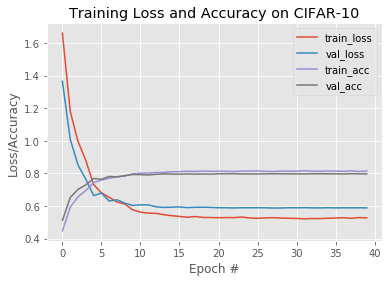

In [8]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#plt.savefig(args["output"])
plt.show()